In [1]:
import math
from typing import List, Optional, Tuple, Union
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch import nn
import os
from torch.utils.data import IterableDataset, Dataset
import json
import numpy as np
from transformers import  PreTrainedModel
from transformers.modeling_outputs import CausalLMOutputWithPast
from transformers import PretrainedConfig
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM, AutoTokenizer, DefaultDataCollator, DataCollatorForTokenClassification, AutoConfig

### RMSNorm 数学公式推导

根据代码实现，`RMSNorm` 类是一个基于均方根归一化（Root Mean Square Normalization）的实现。以下是代码对应的数学公式推导：

#### 假设变量
- 输入张量为 **`x`**，维度为 `(batch_size, sequence_length, hidden_size)`。
- 每个向量是按最后一个维度（`hidden_size`）进行归一化的。

---

### 数学公式表示

1. **计算输入的均方值**：
   对最后一维（`hidden_size`）计算元素的平方均值：
   ```math
   \text{variance} = \frac{1}{n} \sum_{i=1}^{n} x_i^2
   ```
   其中，`n` 是最后一个维度的大小（`hidden_size`），`x_i` 是 `x` 在最后一维的每个元素。

2. **加上稳定项并计算均方根倒数**：
   ```math
   \text{rms} = \sqrt{\text{variance} + \epsilon}
   \quad \Rightarrow \quad
   \text{rsqrt} = \frac{1}{\text{rms}} = \frac{1}{\sqrt{\text{variance} + \epsilon}}
   ```
   其中，`ε` 是一个小的正数（`eps`），用于防止数值不稳定。

3. **归一化输入张量**：
   ```math
   \hat{x}_i = x_i \cdot \text{rsqrt}
   \quad \Rightarrow \quad
   \hat{x} = x \cdot \frac{1}{\sqrt{\text{variance} + \epsilon}}
   ```

4. **应用可学习的缩放参数**：
   ```math
   y = \gamma \cdot \hat{x}
   ```
   其中，`γ` 是形状为 `(hidden_size,)` 的可学习权重参数（`self.weight`）。

---

### 最终公式

将上述步骤合并，RMSNorm 的输出公式为：

```math
y = \gamma \cdot \frac{x}{\sqrt{\frac{1}{n} \sum_{i=1}^{n} x_i^2 + \epsilon}}
```

---

### 关键点解释

- **均方根归一化的特点**：
  与 LayerNorm 不同，RMSNorm 不会减去均值（`mean`），仅使用输入的平方均值进行归一化。
  
- **可学习参数**：
  `γ` 是一个可学习的缩放参数，形状为 `(hidden_size,)`，每个隐藏单元有独立的缩放因子。

---

### Python代码与公式对应关系

- `variance = hidden_states.pow(2).mean(-1, keepdim=True)` 对应于计算均方值：
  ```math
  \text{variance} = \frac{1}{n} \sum_{i=1}^{n} x_i^2
  ```

- `torch.rsqrt(variance + self.variance_epsilon)` 对应于计算均方根的倒数：
  ```math
  \text{rsqrt} = \frac{1}{\sqrt{\text{variance} + \epsilon}}
  ```

- `hidden_states = hidden_states * torch.rsqrt(...)` 对应于归一化：
  ```math
  \hat{x} = x \cdot \frac{1}{\sqrt{\text{variance} + \epsilon}}
  ```

- `self.weight * hidden_states.float()` 对应于乘以可学习的缩放参数 `γ`：
  ```math
  y = \gamma \cdot \hat{x}
  ```

---

### 总结

RMSNorm 的输出是一个经过均方根归一化和可学习缩放的张量，公式为：

```math
y = \gamma \cdot \frac{x}{\sqrt{\frac{1}{n} \sum_{i=1}^{n} x_i^2 + \epsilon}}
```
```

In [4]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

rms_norm = RMSNorm(dim=5, eps=1e-8)
x = torch.randn(1, 3, 5)
output = rms_norm(x)
print(output)


tensor([[[ 0.2347, -1.6276,  1.2847,  0.8005, -0.0655],
         [ 1.1359,  1.5551, -0.5140,  0.9073,  0.4516],
         [ 0.7831,  1.1025, -0.0960,  0.0251, -1.7781]]],
       grad_fn=<MulBackward0>)


In [5]:
x

tensor([[[ 0.1865, -1.2936,  1.0211,  0.6362, -0.0520],
         [ 0.6308,  0.8636, -0.2854,  0.5039,  0.2508],
         [ 1.1604,  1.6337, -0.1422,  0.0371, -2.6349]]])

In [12]:
import math

list1 = [ 0.1865, -1.2936,  1.0211,  0.6362, -0.0520]

variance = sum([x**2 for x in list1]) / len(list1)
print(f"variance: {variance}")


variance: 0.631656572


In [13]:
eps = 1e-8
rms = math.sqrt(variance + eps)
print(f"rms: {rms}")

final = 0.1865 / rms
print(f"final: {final}")


rms: 0.7947682567893612
final: 0.23465959845126075


我们来逐步计算 **`0.2347`** 是如何得出的。首先从输入的张量开始，选择对应的元素进行计算。

---

### 输入张量 `x`（取第一个位置的元素 `0.1865`）：

```text
x = tensor([[[ 0.1865, -1.2936,  1.0211,  0.6362, -0.0520],
             [ 0.6308,  0.8636, -0.2854,  0.5039,  0.2508],
             [ 1.1604,  1.6337, -0.1422,  0.0371, -2.6349]]])
```

我们要计算的输出是第一个值 **`0.2347`**，对应输入张量的第一个值 **`0.1865`**。

---

### 代码逻辑的公式

根据 RMSNorm 定义，归一化公式为：

```math
y = \gamma \cdot \frac{x}{\sqrt{\frac{1}{n} \sum_{i=1}^n x_i^2 + \epsilon}}
```

其中：
- **`x`** 是输入张量的值。
- **`γ`** 是可学习参数（代码中为 `self.weight`，默认为全 1）。
- **`n`** 是最后一维的大小（在这里是 5）。
- **`ε`** 是一个小的正数（`eps=1e-6`）。

我们按照公式一步步计算。

---

### 第一步：计算均方值

取输入张量的第一行（最后一维的向量）：
```text
[ 0.1865, -1.2936,  1.0211,  0.6362, -0.0520 ]
```

计算平方值：
```text
0.1865^2 = 0.0348
(-1.2936)^2 = 1.6734
1.0211^2 = 1.0427
0.6362^2 = 0.4047
(-0.0520)^2 = 0.0027
```

求均值：
```math
\text{variance} = \frac{1}{5}(0.0348 + 1.6734 + 1.0427 + 0.4047 + 0.0027)
                = \frac{3.1583}{5}
                = 0.6317
```

---

### 第二步：加上稳定项并计算均方根倒数

加入稳定项 **`ε = 1e-6`**：
```math
\text{variance} + \epsilon = 0.6317 + 1e-6 = 0.631701
```

计算均方根倒数（`rsqrt`）：
```math
\text{rsqrt} = \frac{1}{\sqrt{0.631701}}
             = \frac{1}{0.7948}
             = 1.2581
```

---

### 第三步：归一化输入值 `x`

用均方根倒数对输入进行归一化，计算第一个值：
```math
\hat{x}_1 = x_1 \cdot \text{rsqrt}
          = 0.1865 \cdot 1.2581
          = 0.2347
```

---

### 第四步：应用可学习参数 `γ`

在代码中，`γ` 的初始值为 1，因此：
```math
y_1 = \gamma \cdot \hat{x}_1
    = 1 \cdot 0.2347
    = 0.2347
```

---

### 最终结果

经过计算，输出的第一个值为 **`0.2347`**，与代码输出一致。

```text
y = tensor([[[ 0.2347, -1.6276,  1.2847,  0.8005, -0.0655], ...]])
```

# ROPE (Rotary Position Embedding) 数学推导

## 从内积角度

设 $\vec{x}_m, \vec{x}_n$ 为 d 维向量，$\Theta$ 为位置编码矩阵，则有：

### 基本定义

$\vec{y}_m = W_q \vec{x}_m e^{im\theta} = (W_q \vec{x}_m) e^{im\theta} = \vec{q}_m e^{im\theta}$ (1)

$\vec{y}_n = W_k \vec{x}_n e^{in\theta} = (W_k \vec{x}_n) e^{in\theta} = \vec{q}_n e^{in\theta}$ (2)

### 内积计算

$\vec{y}_m^T \vec{y}_n = (\vec{q}_m^T \vec{q}_n) \begin{pmatrix} \cos((m-n)\theta) & -\sin((m-n)\theta) \\ \sin((m-n)\theta) & \cos((m-n)\theta) \end{pmatrix} \begin{pmatrix} k_1^T \\ k_2^T \end{pmatrix}$ (3)

展开可得同样的注意力计算公式

### 复数形式表达

$\vec{y}_m = W_q \vec{x}_m e^{im\theta} = (W_q \vec{x}_m) e^{im\theta} = \vec{q}_m e^{im\theta}$

$\therefore \vec{q}_m = \begin{pmatrix} W_q^1 \\ W_q^2 \end{pmatrix} \vec{x}_m = \begin{pmatrix} \vec{q}_m^1 \\ \vec{q}_m^2 \end{pmatrix}$

可以表示为复数形式：$\vec{q}_m = \vec{q}_m^1 + i\vec{q}_m^2$

### 欧拉公式

$(e^{im\theta} + e^{-im\theta}) = \cos(m\theta) + i\sin(m\theta)$

$(W_q \vec{x}_m) e^{im\theta} = \vec{q}_m e^{im\theta} = (\vec{q}_m^1 + i\vec{q}_m^2)(\cos(m\theta) + i\sin(m\theta))$

$= (\vec{q}_m^1 \cos(m\theta) - \vec{q}_m^2 \sin(m\theta)) + i(\vec{q}_m^2 \cos(m\theta) + \vec{q}_m^1 \sin(m\theta))$

$= \begin{pmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{pmatrix} \begin{pmatrix} \vec{q}_m^1 \\ \vec{q}_m^2 \end{pmatrix}$

这就是旋转矩阵形式

### 注意力计算

$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$，V不计算 $QK^T$ 就能得到 (3) 式

## 矩阵形式

$\vec{y}_m = \begin{pmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{pmatrix} \begin{pmatrix} \vec{q}_m^1 \\ \vec{q}_m^2 \end{pmatrix}$

### 矩阵分解

$\begin{pmatrix} \cos m\theta_0 & -\sin m\theta_0 & 0 & 0 & \cdots & 0 & 0 \\ \sin m\theta_0 & \cos m\theta_0 & 0 & 0 & \cdots & 0 & 0 \\ 0 & 0 & \cos m\theta_1 & -\sin m\theta_1 & 0 & 0 & 0 \\ 0 & 0 & \sin m\theta_1 & \cos m\theta_1 & 0 & 0 & 0 \\ \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\ 0 & 0 & 0 & 0 & \cdots & \cos m\theta_{d/2-1} & -\sin m\theta_{d/2-1} \\ 0 & 0 & 0 & 0 & \cdots & \sin m\theta_{d/2-1} & \cos m\theta_{d/2-1} \end{pmatrix} \begin{pmatrix} q_0 \\ q_1 \\ q_2 \\ q_3 \\ \vdots \\ q_{d-2} \\ q_{d-1} \end{pmatrix}$

矩阵可拆分为两个矩阵相乘：

$\begin{pmatrix} q_0 \\ q_1 \\ q_2 \\ q_3 \\ \vdots \\ q_{d-2} \\ q_{d-1} \end{pmatrix} \otimes \begin{pmatrix} \cos m\theta_0 \\ \cos m\theta_0 \\ \cos m\theta_1 \\ \cos m\theta_1 \\ \vdots \\ \cos m\theta_{d/2-1} \\ \cos m\theta_{d/2-1} \end{pmatrix} + \begin{pmatrix} -q_1 \\ q_0 \\ -q_3 \\ q_2 \\ \vdots \\ -q_{d-1} \\ q_{d-2} \end{pmatrix} \otimes \begin{pmatrix} \sin m\theta_0 \\ \sin m\theta_0 \\ \sin m\theta_1 \\ \sin m\theta_1 \\ \vdots \\ \sin m\theta_{d/2-1} \\ \sin m\theta_{d/2-1} \end{pmatrix}$

$\theta_i = 10000^{-2i/d}, i \in [0, 1, \cdots, \frac{d}{2}-1]$

$\theta = 1.0 / (base ** (torch.arange(0, d, 2).float() / d))$, float()

恒等式：$e^{-i\omega t} = \cos(\omega t) - i\sin(\omega t)$

实现时需要计算每种频率的 $m\theta_i$，对第 $m$ 个词，$m\theta_0, m\theta_1, \cdots, m\theta_{d/2-1}$ 要双倍，
对应第 $m$ 行，$m\theta_i$ 要双倍

$xb\_theta2 = torch.cat([xb\_theta[:, :, :, None], xb\_theta[:, :, :, None]], 3)$

$cos\_cached = xb\_theta2[:, :, :, 0].cos()[:, None, None, :]$
$sin\_cached = xb\_theta2[:, :, :, 0].sin()[:, None, None, :]$


In [3]:
import torch

class RoPE:
    def __init__(self, dim):
        """
        初始化RoPE类，计算逆频率（inv_freq），该逆频率用于构建旋转位置编码。

        参数：
        - dim: 输入向量的维度，必须是偶数，因为位置编码是针对偶数索引和奇数索引分别进行的。
        """
        self.dim = dim
        # 计算逆频率inv_freq，维度为`dim // 2`。`torch.arange(0, dim, 2)`生成从0开始到`dim`的偶数索引。
        # `10000`是常见的基数，`torch.arange(0, dim, 2).float() / dim`将偶数索引归一化到[0, 1]的区间。
        # 计算得到的逆频率会用于后续的正弦和余弦函数构造位置编码。
        self.inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
    
    def apply_rotary_pos_emb(self, x, seq_len):
        """
        应用旋转位置编码到输入张量x上。

        参数：
        - x: 输入的张量，形状为(batch_size, seq_len, dim)，表示批量大小、序列长度和维度。
        - seq_len: 序列的长度。

        返回：
        - 返回一个与输入x形状相同的张量，应用了旋转位置编码。
        """
        
        # 生成位置索引，形状为(seq_len, 1)，在序列长度的维度上进行扩展。
        positions = torch.arange(seq_len, device=x.device).unsqueeze(1)
        
        # 将位置索引与逆频率相乘，得到角度，形状为(seq_len, dim // 2)。
        angles = positions * self.inv_freq
        
        # 计算正弦和余弦编码，分别扩展到维度`dim`大小。
        # `sin_emb`和`cos_emb`的形状为(seq_len, dim)。
        sin_emb = torch.sin(angles).repeat(1, 2)  # 重复以适应dim维度
        cos_emb = torch.cos(angles).repeat(1, 2)

        # 使用正弦和余弦编码对输入张量进行旋转。
        # x * cos_emb对输入张量进行缩放，而rotate_half(x) * sin_emb对输入张量进行旋转。
        # 最终结果是将这些值求和得到旋转后的张量。
        x_rotated = x * cos_emb + self.rotate_half(x) * sin_emb
        return x_rotated
    
    def rotate_half(self, x):
        """
        将张量的后一半进行旋转。具体来说，将张量的奇数索引部分变为负值，并交换偶数索引部分和奇数索引部分。

        参数：
        - x: 形状为(batch_size, seq_len, dim)的输入张量。

        返回：
        - 返回一个与输入张量形状相同的张量，但后半部分进行了旋转。
        """
        # 将输入张量的偶数索引部分和奇数索引部分分别取出。
        x1, x2 = x[..., ::2], x[..., 1::2]
        
        # 将奇数索引部分x2变负，并与偶数索引部分x1拼接，交换它们的位置。
        # 最终返回的张量形状仍然是(batch_size, seq_len, dim)。
        return torch.cat([-x2, x1], dim=-1)

# 示例使用
batch_size = 2
seq_len = 6
dim = 4

# 随机生成一个形状为(batch_size, seq_len, dim)的输入张量x。
x = torch.randn(batch_size, seq_len, dim)

# 创建RoPE对象，指定维度dim。
rope = RoPE(dim)

# 应用旋转位置编码到输入张量x上。
x_with_rope = rope.apply_rotary_pos_emb(x, seq_len)

# 打印结果张量的形状，应该与输入张量的形状相同。
print(x_with_rope.shape)

torch.Size([2, 6, 4])


In [14]:
# 旋转操作
def rotate_half(x):
    # 同上：将张量的后一半进行旋转。具体来说，将张量的奇数索引部分变为负值，并交换偶数索引部分和奇数索引部分。
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

# 应用位置编码
def apply_rotate_pos_emb(q, k, cos, sin, unsqueeze_dim=2):
    
    cos = cos.unsqueeze(unsqueeze_dim) # (1, seq_len, 1, dim)
    sin = sin.unsqueeze(unsqueeze_dim) # (1, seq_len, 1, dim)
   
    # (batch_size, seq_len, head_num, dim) * (1, seq_len, 1, dim) = (batch_size, seq_len, head_num, dim) 广播
    q_embed = (q*cos) + (rotate_half(q)*sin) 
    # (batch_size, seq_len, head_num, dim) * (1, seq_len, 1, dim) = (batch_size, seq_len, head_num, dim) 广播 
    k_embed = (k*cos) + (rotate_half(k)*sin)  
    
    return q_embed, k_embed

class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=2048):
        super(RotaryEmbedding, self).__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))  # 形状(dim/2)
        t = torch.arange(max_seq_len).float().unsqueeze(1)  # 形状(max_seq_len, 1)
        freqs = t @ inv_freq.unsqueeze(0)  #(max_seq_len, 1)*(1, dim/2) = (max_seq_len, dim/2)
        freqs = torch.cat((freqs, freqs), dim=-1)  # (max_seq_len, dim)
        
        self.register_buffer("cos_cached", freqs.cos())
        self.register_buffer("sin_cached", freqs.sin())
        
    def forward(self, q, k):
        cos = self.cos_cached[:q.shape[1], :].unsqueeze(0)  # (1, seq_len, dim)
        sin = self.sin_cached[:q.shape[1], :].unsqueeze(0)  # (1, seq_len, dim)
        return apply_rotate_pos_emb(q, k, cos, sin)


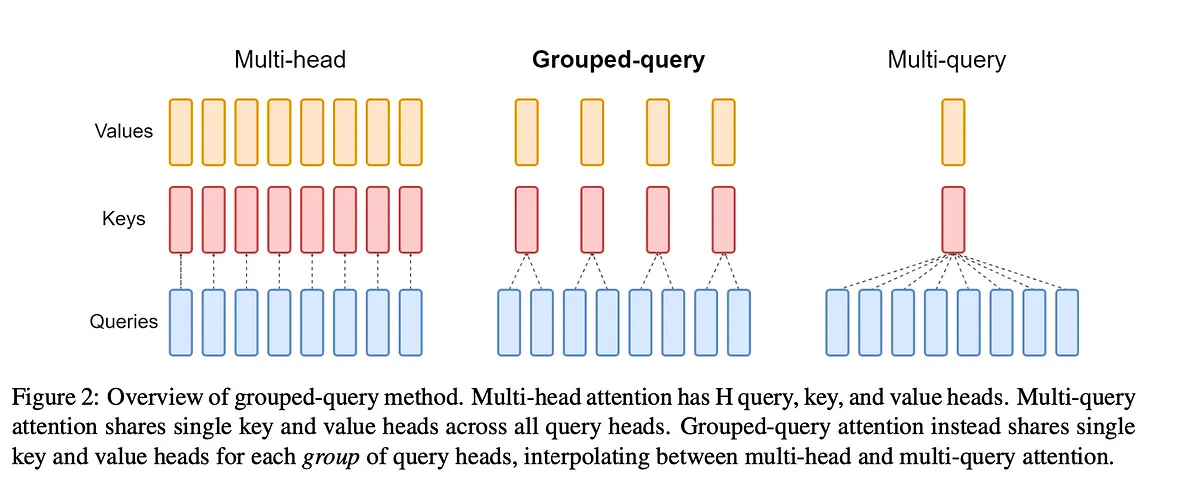

In [2]:
# 对于group query，一个q共享多个k，v，需要对k，v进行复制
def repeat_kv(hidden_states, n_rep): 
    """
    hidden_states: (batch_size, seq_len, num_key_value_heads, head_dim)
    n_rep: 复制次数
    """
    batch, slen, num_key_value_heads, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, :, None, :].expand(batch, slen, num_key_value_heads, n_rep, head_dim)
    return hidden_states.reshape(batch, slen, num_key_value_heads * n_rep, head_dim)

torch.Size([1, 256, 8, 64])


In [ ]:
# 注意力机制
class Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = config.dropout
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = getattr(config, "head_dim", self.hidden_size // self.num_heads)
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.k_cache, self.v_cache = None, None
        self.is_causal = True
        self.flash_attn = self.config.flash_attn

        # 初始化q,k,v变换矩阵
        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=config.attention_bias)
        self.k_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=config.attention_bias)
        self.v_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=config.attention_bias)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias=config.attention_bias)
        self.residual_dropout = nn.Dropout(self.dropout)
        self.attention_dropout = nn.Dropout(self.dropout)
        self.rotary_emb = RotaryEmbedding(self.head_dim)
        
    def forward(self, hidden_states, use_kv_cache=False):
        b, s = hidden_states.shape[:2]
    
        if use_kv_cache and self.eval(): # 使用kv cache，在推理时使用
            if self.k_cache is None or self.k_cache.shape[1] != s-1: # 如果k_cache为空或者k_cache的序列长度不等于s-1
                q, k, v = self.q_proj(hidden_states), self.k_proj(hidden_states), self.v_proj(hidden_states)
            else:
                # 获取最新生成的token
                token = hidden_states[:, -1:, :] # 形状(b, 1, dim)
                q = torch.cat((torch.zeros_like(hidden_states[:, :-1, :]), self.q_proj(token)), dim=1) 
                # 新的k,v和之前已经生成的进行拼接
                k = torch.cat((self.k_cache, self.k_proj(token)), dim=1)
                v = torch.cat((self.v_cache, self.v_proj(token)), dim=1)
            # 更新cache
            self.k_cache, self.v_cache = k, v
            
        else:
            q, k, v = self.q_proj(hidden_states), self.k_proj(hidden_states), self.v_proj(hidden_states)
            
        q = q.view(b, s, self.num_heads, self.head_dim)
        k = k.view(b, s, self.num_key_value_heads, self.head_dim)
        v = v.view(b, s, self.num_key_value_heads, self.head_dim)
        
        q, k = self.rotary_emb(q, k)
        
        k = repeat_kv(k, self.num_key_value_groups)
        v = repeat_kv(v, self.num_key_value_groups)
        
        q = q.transpose(1, 2) # b, self.num_heads, s, self.head_dim
        k = k.transpose(1, 2) # b, self.num_heads, s, self.head_dim
        v = v.transpose(1, 2) # b, self.num_heads, s, self.head_dim
        
        if self.flash_attn:
        
            # q*k转置，（b, self.num_heads, s, self.head_dim）* (b, self.num_heads, self.head_dim，s) = （b, self.num_heads, s, s）
            # q*k/sqrt(self.head_dim)*v  （b, self.num_heads, s, s）* (b, self.num_heads, s, self.head_dim) = b, self.num_heads, s, self.head_dim
            output = F.scaled_dot_product_attention(q, k, v, attn_mask=None, 
                                                    dropout_p=self.dropout if self.training else 0.0, 
                                                    is_causal=self.is_causal) 
        else:
            mask = torch.full((1, 1, self.config.max_seq_len, self.config.max_seq_len), float("-inf"))  # 初始化掩码
            mask = torch.triu(mask, diagonal=1)  # 生成上三角掩码
            scores = torch.matmul(q, k.transpose(2, 3)) / math.sqrt(self.head_dim)  # 计算注意力分数
            scores = scores + self.mask[:, :, :s, :s]  # 应用掩码
            scores = F.softmax(scores.float(), dim=-1).type_as(q)  # 计算 softmax
            scores = self.attention_dropout(scores)  # 应用注意力 dropout
            output = torch.matmul(scores, v)  # 计算输出
        
        output = output.transpose(1, 2).contiguous().view(b, s, -1) # b, s, self.hidden_size
        
        output = self.o_proj(output)
        output = self.residual_dropout(output)
        return output
                

In [1]:
import torch
import torch.nn as nn

class GroupedQueryAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, num_query_groups, dropout=0.1):
        """
        初始化 GQA 模块。

        Args:
            embed_dim (int): 输入嵌入的维度 (d_model)。
            num_heads (int): 注意力头的数量。
            num_query_groups (int): 查询向量的分组数量。
            dropout (float): 用于注意力权重的 dropout 概率。
        """
        super(GroupedQueryAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        assert num_heads % num_query_groups == 0, "Number of heads must be divisible by number of query groups"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_query_groups = num_query_groups
        self.head_dim = embed_dim // num_heads
        self.group_size = num_heads // num_query_groups

        # 定义线性投影层
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        # Dropout 层
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        """
        前向传播。

        Args:
            query (Tensor): 查询张量，形状为 (batch_size, seq_len, embed_dim)。
            key (Tensor): 键张量，形状为 (batch_size, seq_len, embed_dim)。
            value (Tensor): 值张量，形状为 (batch_size, seq_len, embed_dim)。
            mask (Tensor, optional): 注意力掩码，形状为 (batch_size, 1, 1, seq_len)。

        Returns:
            Tensor: 输出张量，形状为 (batch_size, seq_len, embed_dim)。
        """
        batch_size, seq_len, _ = query.size()

        # 线性投影到多头注意力的 q, k, v
        q = self.q_proj(query)  # (batch_size, seq_len, embed_dim)
        k = self.k_proj(key)    # (batch_size, seq_len, embed_dim)
        v = self.v_proj(value)  # (batch_size, seq_len, embed_dim)

        # 将 q, k, v reshape 为多头形式
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)

        # 对查询向量进行分组，每组共享一组注意力头。相当于 self.num_query_groups * self.group_size = self.num_heads 个注意力头
        q_groups = q.view(batch_size, self.num_query_groups, self.group_size, seq_len, self.head_dim)  # (batch_size, num_query_groups, group_size, seq_len, head_dim)
        k_groups = k.view(batch_size, self.num_query_groups, self.group_size, seq_len, self.head_dim)  # (batch_size, num_query_groups, group_size, seq_len, head_dim)
        v_groups = v.view(batch_size, self.num_query_groups, self.group_size, seq_len, self.head_dim)  # (batch_size, num_query_groups, group_size, seq_len, head_dim)

        # 计算注意力分数
        attn_scores = torch.einsum("bngqs,bngks->bngqk", q_groups, k_groups)  # (batch_size, num_query_groups, group_size, seq_len, seq_len)
        attn_scores = attn_scores / (self.head_dim ** 0.5)  # 缩放

        # 应用注意力掩码（如果提供了）
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float("-inf"))

        # 计算注意力权重
        attn_weights = torch.softmax(attn_scores, dim=-1)  # (batch_size, num_query_groups, group_size, seq_len, seq_len)
        attn_weights = self.attn_dropout(attn_weights)  # Dropout

        # 加权求和得到注意力输出
        attn_output = torch.einsum("bngqk,bngkv->bngqv", attn_weights, v_groups)  # (batch_size, num_query_groups, group_size, seq_len, head_dim)

        # 合并分组维度
        attn_output = attn_output.view(batch_size, self.num_heads, seq_len, self.head_dim).transpose(1, 2)  # (batch_size, seq_len, num_heads, head_dim)
        attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)  # (batch_size, seq_len, embed_dim)

        # 输出投影
        output = self.out_proj(attn_output)  # (batch_size, seq_len, embed_dim)
        output = self.proj_dropout(output)

        return output

### 代码说明

1. **模块初始化**：
   - `embed_dim` 是输入的嵌入维度，通常等于 Transformer 的 `d_model`。
   - `num_heads` 是多头注意力的头数。
   - `num_query_groups` 是 GQA 的查询分组数量。
   - 每个分组处理 `group_size = num_heads // num_query_groups` 个头。

2. **线性投影**：
   - 输入的 `query`、`key` 和 `value` 通过线性层分别投影到 `q`, `k`, `v`。
   - 这些是标准的多头注意力机制中的步骤。

3. **分组查询**：
   - 将 `q`, `k`, `v` reshape 成分组形式，其中查询分组共享一组注意力头，减少了计算量。

4. **注意力权重计算**：
   - 使用 `torch.einsum` 计算注意力分数。
   - 注意力分数按维度缩放，随后应用 softmax 和 dropout。

5. **加权求和**：
   - 利用注意力权重对 `v` 进行加权求和，得到注意力输出。

6. **输出处理**：
   - 将分组形式的输出还原成原始的多头形式。
   - 通过输出投影层将注意力输出映射回嵌入维度。

# torch.einsum 爱因斯坦求和

- torch.einsum 是 torch 库中的一个函数，用于执行爱因斯坦求和约定（Einstein summation convention）。

- 它允许用户以一种简洁的方式表示复杂的张量操作，特别是在处理多维数组时。

- 爱因斯坦求和约定是一种表示张量操作的符号表示法，它将张量操作表示为符号的缩写。

例如，torch.einsum("bngqs,bngks->bngqk", q_groups, k_groups) 表示对 q_groups 和 k_groups 进行矩阵乘法，

其中 "bngqs,bngks->bngqk" 表示 q_groups 和 k_groups 的维度分别为 (batch_size, num_query_groups, group_size, seq_len, head_dim) 和 (batch_size, num_query_groups, group_size, seq_len, head_dim)。

这个操作的结果是一个形状为 (batch_size, num_query_groups, group_size, seq_len, seq_len) 的张量，表示注意力分数。

- 实际上很简单：就是对目标维度进行矩阵乘法，得到注意力分数。


In [2]:
# 示例输入
batch_size = 2
seq_len = 10
embed_dim = 64
num_heads = 8
num_query_groups = 4

# 创建 GQA 模块
gqa = GroupedQueryAttention(embed_dim=embed_dim, num_heads=num_heads, num_query_groups=num_query_groups)

# 随机生成输入
query = torch.randn(batch_size, seq_len, embed_dim)
key = torch.randn(batch_size, seq_len, embed_dim)
value = torch.randn(batch_size, seq_len, embed_dim)

# 前向传播
output = gqa(query, key, value)
print("Output shape:", output.shape)  # 应输出 (batch_size, seq_len, embed_dim)

Output shape: torch.Size([2, 10, 64])
